Всякая подготовка фигни

In [ ]:
# ВНИМАНИЕ; версия Pillow установвленна по умолчанию - '7.0.0'
# Эта версия ломает torchvision
import PIL
PIL.__version__

'7.0.0'

In [1]:
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

Uninstalling Pillow-7.0.0:
  Successfully uninstalled Pillow-7.0.0
Created temporary directory: /tmp/pip-ephem-wheel-cache-wwafcuwm
Created temporary directory: /tmp/pip-req-tracker-kpuekzim
Created requirements tracker '/tmp/pip-req-tracker-kpuekzim'
Created temporary directory: /tmp/pip-install-pgm5tqtu
1 location(s) to search for versions of Pillow:
* https://pypi.org/simple/pillow/
Getting page https://pypi.org/simple/pillow/
Found index url https://pypi.org/simple
Looking up "https://pypi.org/simple/pillow/" in the cache
Request header has "max_age" as 0, cache bypassed
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /simple/pillow/ HTTP/1.1" 200 179005
Updating cache with response from "https://pypi.org/simple/pillow/"
Caching due to etag
Analyzing links from page https://pypi.org/simple/pillow/
  Found link https://files.pythonhosted.org/packages/72/e6/692512c5d9dc97f83a91f8a75806e0b9e910ebd8d6b0b3d6ca9a249c1e26/Pillow-1.0.tar.gz#sha256=be8643522995b496

Обязательно перезагрузить рантайм (Runtime -> Restart Runtime). Иначе версия 5.3.0 не будет загружена в рантайм.

После перезапуска рантайма следует продолжить исполнять ячейки далее.

In [1]:
!pip install -U torch torchvision

     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 12.8MB 252kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
!pip install -q 'https://download.pytorch.org/whl/cu101/torch-1.7.1%2Bcu101-cp36-cp36m-linux_x86_64.whl' torchvision
import torch

     |████████████████████████████████| 735.4MB 24kB/s 


In [3]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


скачайте датасет с каггла и положите его в корень своего гугл диска

In [5]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip #распаковка датасета

In [6]:
!ls train

simpsons_dataset


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Feb  6 15:35:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

Данные

In [8]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [33]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")
DEVICE 

device(type='cuda')

In [34]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа

        #добавили аугментацию для трейна
        if self.mode == 'train':
            transform = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)), #режет к нужному размеру
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #наложение фильтров яркости, контраста, насыщенности
            transforms.RandomRotation(25), #случайный поворот картинки
            transforms.RandomHorizontalFlip(), #перевернет изображение по горизонтали
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)), #режет к нужному размеру
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])

        x = self.load_sample(self.files[index])    
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label]) #перевод текста в числа
            y = label_id.item()
            return x, y
        

In [11]:
#для вывода картинок на графике
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [35]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg'))) # находит по шаблону
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [36]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Балансировка классов (Oversampling) - докинем всех картинок в каждом классе до 100 хотя бы

In [ ]:
np.unique(train_val_labels) #наши лейблы

array(['abraham_grampa_simpson', 'agnes_skinner',
       'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
       'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
       'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
       'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
       'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
       'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
       'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
       'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
       'otto_mann', 'patty_bouvier', 'principal_skinner',
       'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
       'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
       'troy_mcclure', 'waylon_smithers'], dtype='<U24')

In [37]:
#погнали балансировать
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [15]:
#полезные функции
def create_dct_path_labels(train_files, train_labels): #словарь с лейблами и путями к ним (чтобы не перегружать диск лишней инфой)
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [38]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)
# Посмотрим, что у нас получилось.
#print_dct(dct_path_train)

In [39]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [40]:
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [19]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [41]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

# выведим на печать класс:количесвто картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [42]:
#Отлично, мы видим, что теперь все классы имеют минимум 100 картинок. У нас получилось.
#картинки если что разбавляем аугментацией, чтобы не одни и те же были в выборке
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train') 

Посмотрим на картинки

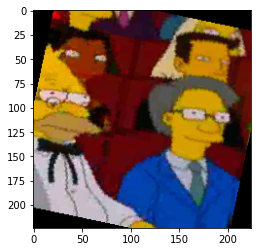

In [ ]:
#нарисовать одну рандомную картинку из трейна
random_character = np.random.randint(1000)
im_val, label = new_train_dataset[random_character]

inp = im_val.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.imshow(inp)

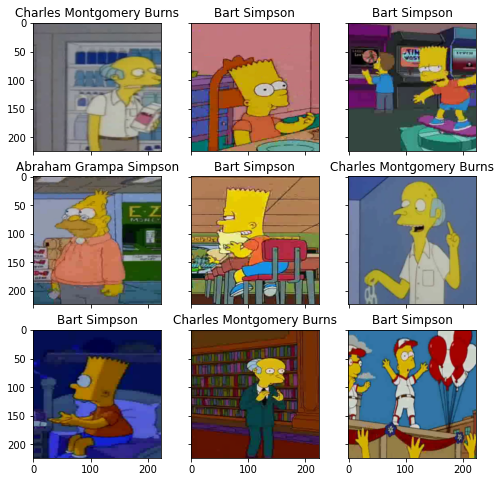

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_'))) #перевели числа в текст
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
# train_dataloader = DataLoader(
#     new_train_dataset, batch_size=32,
#     shuffle=True
# )
# val_dataloader = DataLoader(
#     val_dataset, batch_size=128, #батч сайз для валидации выше, тк при ней мы не обучаем сетку
#     shuffle=False 
# )

# loaders = {
#     "train": train_dataloader,
#     "valid": val_dataloader
# }

# dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

In [ ]:
# print(dataset_sizes)

{'train': 16895, 'val': 5234}


In [ ]:
# # определим загрузщики данных без взвешивания классов для их балансировки простой вариант
# BATCH_SIZE = 128
# # DataLoader достаёт данные из dataset батчами
# dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
#                'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
# dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

Сетка: ResNet18

In [22]:
from torchvision import transforms, models

In [ ]:
# Создаём сеть
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# замораживаем параметры (веса)
# хотим обучить только классификатор и не трогать фича-экстрактор
for param in model.parameters(): #заморозим все параметры кроме последнего слоя
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model.fc = nn.Linear(num_features, 42)

# Обучаем только классификатор
optimizer = torch.optim.AdamW(model.fc.parameters())

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [25]:
def train(train_files, val_files, model, epochs, batch_size, optimizer):
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer #тут определяем оптимизацию
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
resnet18 = model.to(DEVICE)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Запуск обучения

In [ ]:
torch.cuda.empty_cache() #очистка кэша

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [ ]:
train_dataset = new_train_dataset
val_dataset = val_dataset

In [ ]:
history = train(train_dataset, val_dataset, model=resnet18, epochs=10, batch_size=64, optimizer=optimizer) 

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.511003658679083


epoch:  10%|█         | 1/10 [03:36<32:27, 216.42s/it]


Epoch 001 train_loss: 2.5110     val_loss 1.8960 train_acc 0.3670 val_acc 0.5445
loss 1.6887414398472773


epoch:  20%|██        | 2/10 [07:10<28:46, 215.86s/it]


Epoch 002 train_loss: 1.6887     val_loss 1.5014 train_acc 0.5776 val_acc 0.6131
loss 1.421571295612061


epoch:  30%|███       | 3/10 [10:46<25:09, 215.63s/it]


Epoch 003 train_loss: 1.4216     val_loss 1.3953 train_acc 0.6301 val_acc 0.6347
loss 1.285953147632196


epoch:  40%|████      | 4/10 [14:21<21:33, 215.52s/it]


Epoch 004 train_loss: 1.2860     val_loss 1.3317 train_acc 0.6562 val_acc 0.6389
loss 1.2033682233449727


epoch:  50%|█████     | 5/10 [17:55<17:55, 215.02s/it]


Epoch 005 train_loss: 1.2034     val_loss 1.2422 train_acc 0.6778 val_acc 0.6677
loss 1.1507267954505453


epoch:  60%|██████    | 6/10 [21:29<14:19, 214.76s/it]


Epoch 006 train_loss: 1.1507     val_loss 1.2706 train_acc 0.6865 val_acc 0.6521
loss 1.1111095132895494


epoch:  70%|███████   | 7/10 [25:03<10:43, 214.63s/it]


Epoch 007 train_loss: 1.1111     val_loss 1.2182 train_acc 0.6930 val_acc 0.6662
loss 1.0744791169602619


epoch:  80%|████████  | 8/10 [28:38<07:09, 214.66s/it]


Epoch 008 train_loss: 1.0745     val_loss 1.1930 train_acc 0.7080 val_acc 0.6735
loss 1.0446595936634373


epoch:  90%|█████████ | 9/10 [32:13<03:34, 214.68s/it]


Epoch 009 train_loss: 1.0447     val_loss 1.1788 train_acc 0.7091 val_acc 0.6798
loss 1.041832547796023


epoch: 100%|██████████| 10/10 [35:48<00:00, 214.81s/it]


Epoch 010 train_loss: 1.0418     val_loss 1.1673 train_acc 0.7090 val_acc 0.6796


Графики

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

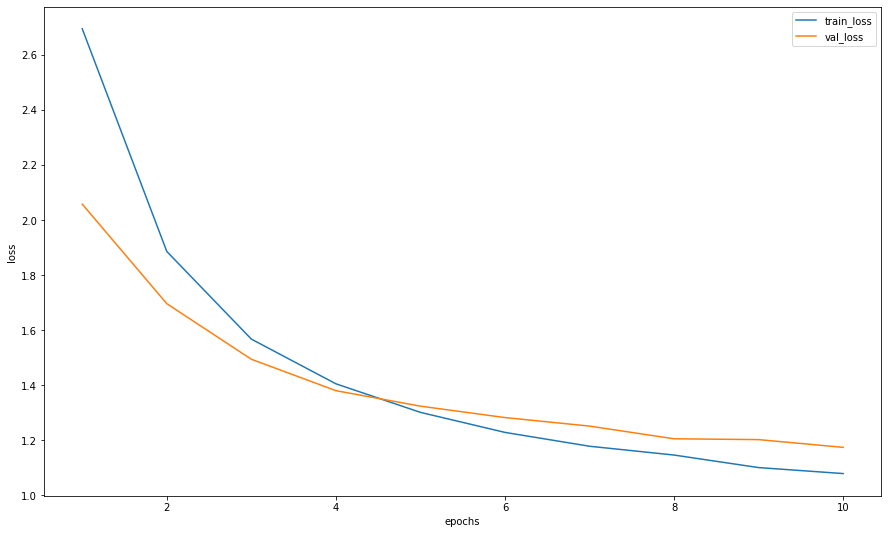

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(np.arange(1, len(loss)+1), loss, label="train_loss")
plt.plot(np.arange(1, len(loss)+1), val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

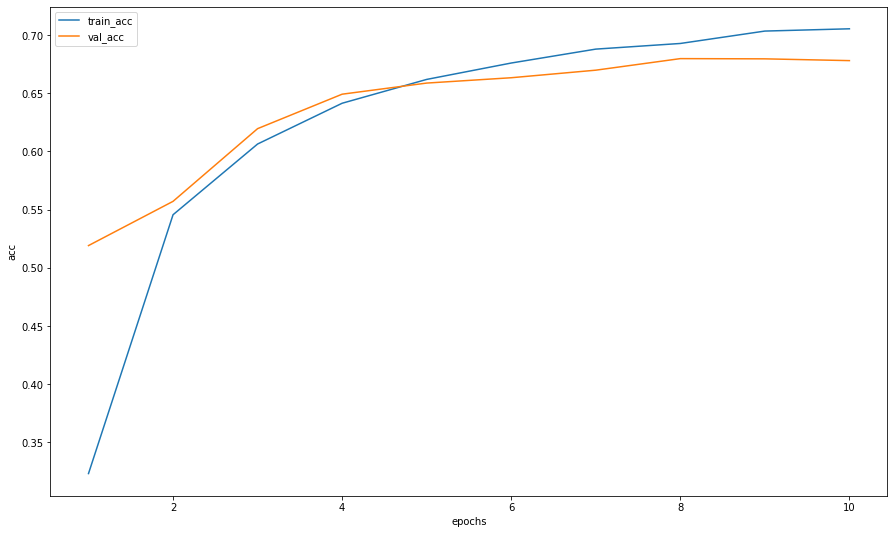

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(np.arange(1, len(loss)+1), acc, label="train_acc")
plt.plot(np.arange(1, len(loss)+1), val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Предсказания

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet18, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet18, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1) #predictions

actual_labels = [val_dataset[id][1] for id in idxs] #actual

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.85

Посмотрим, как хорошо предсказываем классы

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
    
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    
def show_confusion_matrix_fucn(model, classes_number):
    """Построить и посчитать точность классов по confusion matrix"""
    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()

    # Пройдём по всему validation датасету и запишем ответы сети
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            predictions = model(inputs.to(DEVICE))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)

            # Аналог append для list
            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()

    # Функция из sklearn, создаёт confusion матрицу
    cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
    # Выведем её
    plot_confusion_matrix(cm, feature_names, normalize=True)
    
    return y_test_all, predictions_all
  
def accurancy_for_each_class(y_test_all, predictions_all, classes_number):
    class_correct = [0 for i in range(classes_number)]
    class_total = [0 for i in range(classes_number)]
    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(classes_number):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [ ]:
BATCH_SIZE = 128
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Normalized confusion matrix


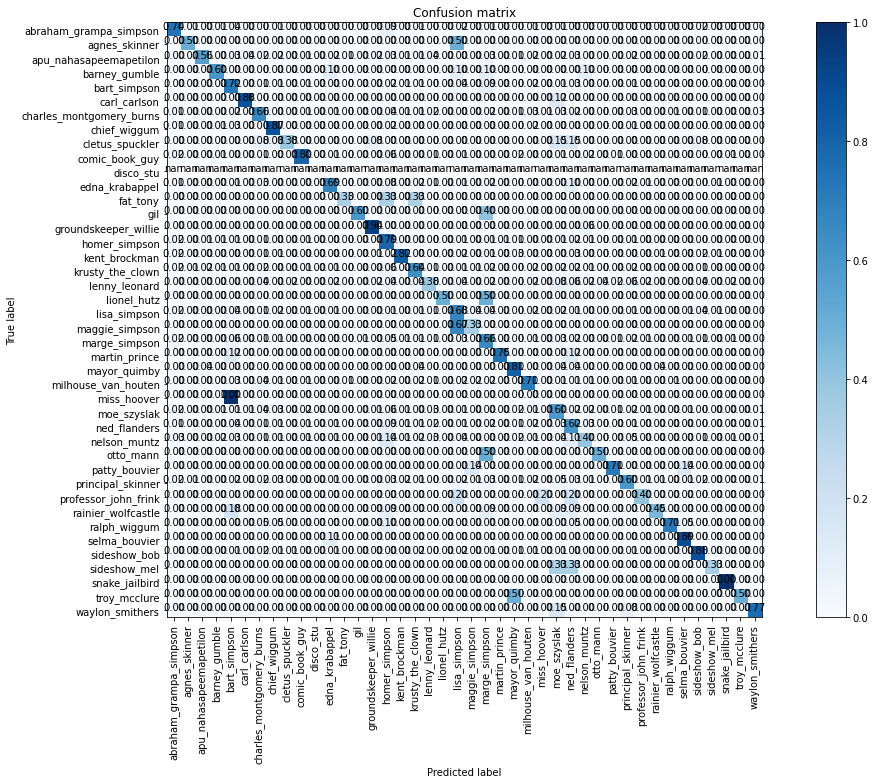

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all = show_confusion_matrix_fucn(resnet18, 42)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, 42)

[217, 2, 248, 10, 301, 8, 334, 214, 13, 101, 0, 118, 3, 5, 16, 442, 117, 405, 50, 2, 385, 3, 311, 8, 27, 282, 1, 444, 407, 108, 2, 7, 391, 5, 11, 21, 9, 186, 3, 2, 2, 13]
42
Accuracy of abraham_grampa_simpson : 74 %
Accuracy of agnes_skinner : 50 %
Accuracy of apu_nahasapeemapetilon : 56 %
Accuracy of barney_gumble : 60 %
Accuracy of bart_simpson : 71 %
Accuracy of carl_carlson : 87 %
Accuracy of charles_montgomery_burns : 65 %
Accuracy of chief_wiggum : 87 %
Accuracy of cletus_spuckler : 38 %
Accuracy of comic_book_guy : 80 %
Accuracy of disco_stu : -1 %
Accuracy of edna_krabappel : 68 %
Accuracy of fat_tony : 33 %
Accuracy of   gil : 60 %
Accuracy of groundskeeper_willie : 93 %
Accuracy of homer_simpson : 78 %
Accuracy of kent_brockman : 82 %
Accuracy of krusty_the_clown : 63 %
Accuracy of lenny_leonard : 38 %
Accuracy of lionel_hutz : 50 %
Accuracy of lisa_simpson : 67 %
Accuracy of maggie_simpson : 33 %
Accuracy of marge_simpson : 65 %
Accuracy of martin_prince : 75 %
Accuracy of m

Сохраним веса

In [ ]:
import copy

# сохранить веса нашей нейросети model
model_weights = copy.deepcopy(model.state_dict())
torch.save(model_weights, "path_to\\model_wights_resnet18.pth") 

затем нам необходимо загрузить состояние ее весов.

1. Если сама нейросеть model у нас уже объявлена. 

Например мы обучали нейросеть 15 эпох, но увидели по функциям потерь, что сеть не доучилась. Мы сохранили ее веса в файл "path_to\\model_wights.pth", и продолжили ее обучение еще на 15 эпох. Увидели, что сеть переобучилась и дает результат хуже чем было до повторного обучения.

загрузим веса немного недообученной сети.

In [ ]:
# # загружаем сохраненное состояние весов нейросети
# model.load_state_dict(torch.load("path_to\\model_wights.pth"))
# model.eval()# переключаем нейросеть в режим обучения

2. Если не объявлена.

Однако допустим у нас другая ситуация. Мы обучали нейросеть в Google Colab, ушли на 2 часа, соединение с Google Colab было потеряно. Мы вернулись, зашли в Google Colab, загружаем наш jupiter notebook и видим, что сеть все равно доучилась на виртуальной машине, а ее веса были сохранены в файл на вашем Google Drive , благодаря ячейке.

In [ ]:
# # сохранить веса нашей нейросети model
# torch.save(model.state_dict(), "path_to\\model_weights.pth") 

Как загрузить нейросеть с этими весами ? Так же как в п. 1 но вначале нам надо будет запустить все ячейки готовящие данные и объявляющие нашу нейросеть. Дело в том, что "model.state_dict()" хранит только значения весов нашей нейросети, но не саму модель.

Сетка 2: Simple CNN model

In [ ]:
# ModelCnn

import torch.nn as nn
import torch.nn.functional as F  # Functional

class ModelCnn(nn.Module):
  
    def __init__(self, n_classes):
        
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(6 * 6 * 128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(1024, n_classes)
        )  

  
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        

        x = F.interpolate(x, size=(6, 6), mode='bilinear')  # resize to the size expected by the linear unit
        x = x.view(x.size(0), 6 * 6 * 128)
    
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        x = self.fc4(x)
        
        return x

In [ ]:
### Создадим модель нейросети и проверим, что в ней те слои, которые нам нужны. ###
# ModelCnn
n_classes = len(np.unique(train_val_labels))
model_cnn = ModelCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(model_cnn)

we will classify :42
ModelCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
train_dataset = new_train_dataset
val_dataset = val_dataset
optimizer = torch.optim.AdamW(model_cnn.parameters())

In [ ]:
### Запустим обучение (Train) нейросети ###
# model_cnn
history = train(train_dataset, val_dataset, model=model_cnn, epochs=10, batch_size=32, optimizer=optimizer)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


loss 2.097901273733344


epoch:  10%|█         | 1/10 [03:33<32:00, 213.44s/it]


Epoch 001 train_loss: 2.0979     val_loss 1.2951 train_acc 0.4299 val_acc 0.6257
loss 1.364951706913386


epoch:  20%|██        | 2/10 [07:07<28:28, 213.53s/it]


Epoch 002 train_loss: 1.3650     val_loss 0.9973 train_acc 0.6183 val_acc 0.7197
loss 0.9790445862560098


epoch:  30%|███       | 3/10 [10:39<24:51, 213.12s/it]


Epoch 003 train_loss: 0.9790     val_loss 0.8583 train_acc 0.7196 val_acc 0.7629
loss 0.7794741598026539


epoch:  40%|████      | 4/10 [14:10<21:15, 212.62s/it]


Epoch 004 train_loss: 0.7795     val_loss 0.6802 train_acc 0.7760 val_acc 0.8101
loss 0.6473991142412232


epoch:  50%|█████     | 5/10 [17:41<17:40, 212.11s/it]


Epoch 005 train_loss: 0.6474     val_loss 0.6184 train_acc 0.8128 val_acc 0.8391
loss 0.5566050989771073


epoch:  60%|██████    | 6/10 [21:12<14:06, 211.63s/it]


Epoch 006 train_loss: 0.5566     val_loss 0.5433 train_acc 0.8398 val_acc 0.8533
loss 0.4859286582798039


epoch:  70%|███████   | 7/10 [24:42<10:33, 211.27s/it]


Epoch 007 train_loss: 0.4859     val_loss 0.5783 train_acc 0.8597 val_acc 0.8600
loss 0.434525085501009


epoch:  80%|████████  | 8/10 [28:12<07:01, 210.90s/it]


Epoch 008 train_loss: 0.4345     val_loss 0.4973 train_acc 0.8762 val_acc 0.8739
loss 0.37554352739817576


epoch:  90%|█████████ | 9/10 [31:42<03:30, 210.65s/it]


Epoch 009 train_loss: 0.3755     val_loss 0.5106 train_acc 0.8900 val_acc 0.8752
loss 0.3706780279448273


epoch: 100%|██████████| 10/10 [35:12<00:00, 211.29s/it]


Epoch 010 train_loss: 0.3707     val_loss 0.4572 train_acc 0.8957 val_acc 0.8892


Графики

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

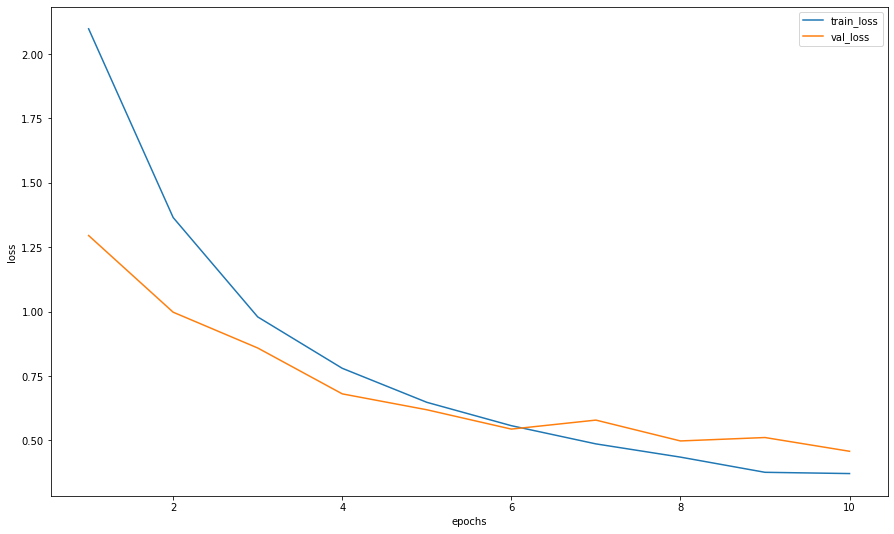

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(np.arange(1, len(loss)+1), loss, label="train_loss")
plt.plot(np.arange(1, len(loss)+1), val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

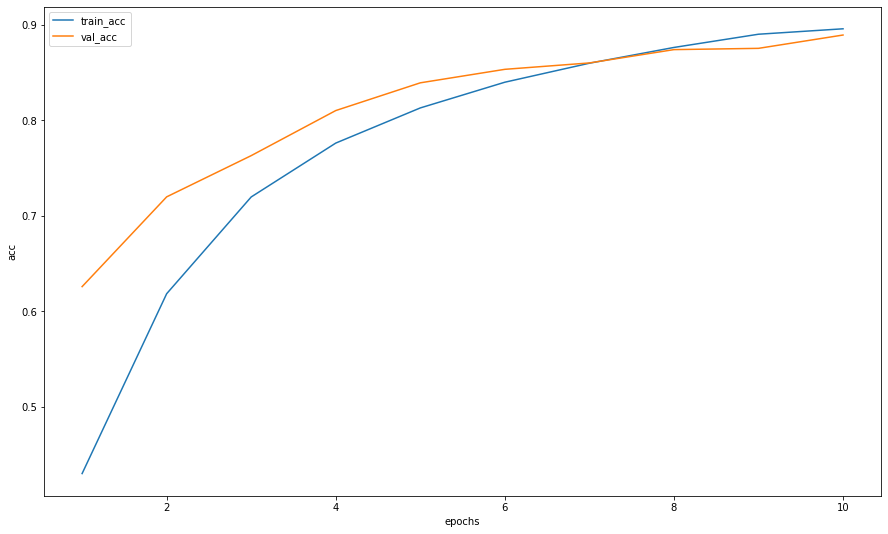

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(np.arange(1, len(loss)+1), acc, label="train_acc")
plt.plot(np.arange(1, len(loss)+1), val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Предсказания

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_cnn, ex_img.unsqueeze(0))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_cnn, imgs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1) #predictions

actual_labels = [val_dataset[id][1] for id in idxs] #actual

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.85

Посмотрим, как хорошо предсказываем классы

In [71]:
import itertools
from sklearn.metrics import confusion_matrix
    
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    
def show_confusion_matrix_fucn(model, classes_number):
    """Построить и посчитать точность классов по confusion matrix"""
    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()

    # Пройдём по всему validation датасету и запишем ответы сети
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            predictions = model(inputs.to(DEVICE))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)

            # Аналог append для list
            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()

    # Функция из sklearn, создаёт confusion матрицу
    cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
    # Выведем её
    plot_confusion_matrix(cm, feature_names, normalize=True)
    
    return y_test_all, predictions_all
  
def accurancy_for_each_class(y_test_all, predictions_all, classes_number):
    class_correct = [0 for i in range(classes_number)]
    class_total = [0 for i in range(classes_number)]
    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(classes_number):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [ ]:
BATCH_SIZE = 128
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Normalized confusion matrix


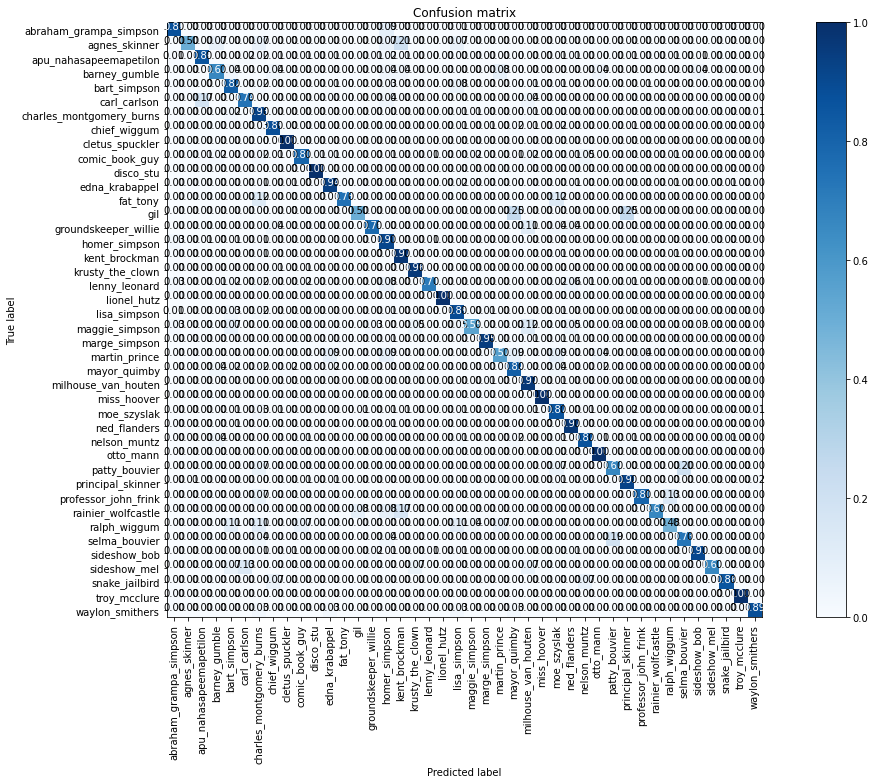

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all = show_confusion_matrix_fucn(model_cnn, 42)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, 42)

[233, 14, 172, 24, 363, 23, 255, 264, 6, 127, 1, 109, 8, 4, 27, 542, 116, 307, 99, 1, 322, 40, 330, 23, 56, 249, 4, 379, 350, 85, 4, 15, 306, 15, 12, 27, 26, 231, 15, 14, 1, 35]
42
Accuracy of abraham_grampa_simpson : 87 %
Accuracy of agnes_skinner : 50 %
Accuracy of apu_nahasapeemapetilon : 86 %
Accuracy of barney_gumble : 66 %
Accuracy of bart_simpson : 82 %
Accuracy of carl_carlson : 73 %
Accuracy of charles_montgomery_burns : 92 %
Accuracy of chief_wiggum : 88 %
Accuracy of cletus_spuckler : 100 %
Accuracy of comic_book_guy : 79 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 93 %
Accuracy of fat_tony : 75 %
Accuracy of   gil : 50 %
Accuracy of groundskeeper_willie : 77 %
Accuracy of homer_simpson : 91 %
Accuracy of kent_brockman : 97 %
Accuracy of krusty_the_clown : 95 %
Accuracy of lenny_leonard : 70 %
Accuracy of lionel_hutz : 100 %
Accuracy of lisa_simpson : 89 %
Accuracy of maggie_simpson : 55 %
Accuracy of marge_simpson : 94 %
Accuracy of martin_prince : 56 %
Acc

Сохраним веса

In [ ]:
import copy

# сохранить веса нашей нейросети model
model_weights = copy.deepcopy(model_cnn.state_dict())
torch.save(model_weights, "path_to\\model_wights_cnn_simple.pth") 

Ансамбль: ResNet18 + SimpleCNN

In [ ]:
#Число входных нейронов этого линейного слоя равно сумме выходов от всех 
# наших моделей из которых мы делаем ансамбль(так как каждая из них предсказывает
# число классов class_numbers * 3), а число выходных равно числу class_numbers.

class MyEnsemble(nn.Module):   
    def __init__(self, modelA, modelB, classes_number):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(classes_number * 2, classes_number)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(x)
        return x

загрузим веса моделей из которых хотим сделать ансамбль: 

In [ ]:
# Зададим путь для загрузки моделей!
path_resnet18 = 'path_to\model_wights_resnet18.pth'
path_model_cnn = 'path_to\model_wights_cnn_simple.pth'

In [ ]:
# Загружаем state dicts
resnet18.load_state_dict(torch.load(path_resnet18))
model_cnn.load_state_dict(torch.load(path_model_cnn))

<All keys matched successfully>

In [ ]:
model_ensemble = MyEnsemble(resnet18, model_cnn, 42).to(DEVICE)

Оставляем для обучения только веса классификатора от ансамбля, наши нейросети уже хорошо научены на симпсонов. 

In [ ]:
# замораживаем параметры (веса) не входящие в layers_to_unfreeze
# обучаем только классификатор
for param in model_ensemble.parameters():
    param.requires_grad = False

for param in model_ensemble.classifier.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим у model_ensemble
print(model_ensemble)

MyEnsemble(
  (modelA): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

теперь подбираем оптимальный lr для нашего ансамбля 

Ну и все обучаем нашу нейросеть-ансамбль (ее классификатор) model_ensemble. Нейросеть сама подстроит веса так чтобы давать лучший прогноз.

In [ ]:
train_dataset = new_train_dataset
val_dataset = val_dataset
optimizer = torch.optim.AdamW(model_ensemble.classifier.parameters()) #обучаем классификатор

In [ ]:
### Запустим обучение (Train) нейросети ###
# model_cnn
history = train(train_dataset, val_dataset, model=model_ensemble, epochs=5, batch_size=32, optimizer=optimizer)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


loss 0.9577975307371038


epoch:  20%|██        | 1/5 [03:37<14:30, 217.65s/it]


Epoch 001 train_loss: 0.9578     val_loss 0.4176 train_acc 0.7912 val_acc 0.8978
loss 0.2552462759914748


epoch:  40%|████      | 2/5 [07:15<10:52, 217.57s/it]


Epoch 002 train_loss: 0.2552     val_loss 0.3631 train_acc 0.9332 val_acc 0.9081
loss 0.2045400660589765


epoch:  60%|██████    | 3/5 [10:52<07:15, 217.62s/it]


Epoch 003 train_loss: 0.2045     val_loss 0.3481 train_acc 0.9440 val_acc 0.9110
loss 0.1834659233638594


epoch:  80%|████████  | 4/5 [14:30<03:37, 217.68s/it]


Epoch 004 train_loss: 0.1835     val_loss 0.3411 train_acc 0.9479 val_acc 0.9142
loss 0.17276086651580366


epoch: 100%|██████████| 5/5 [18:07<00:00, 217.59s/it]


Epoch 005 train_loss: 0.1728     val_loss 0.3437 train_acc 0.9504 val_acc 0.9127


Графики

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

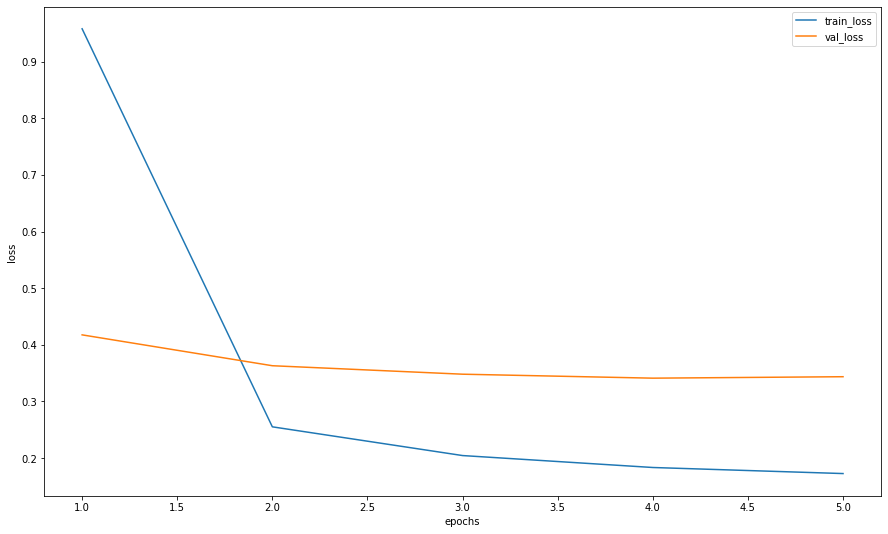

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(np.arange(1, len(loss)+1), loss, label="train_loss")
plt.plot(np.arange(1, len(loss)+1), val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

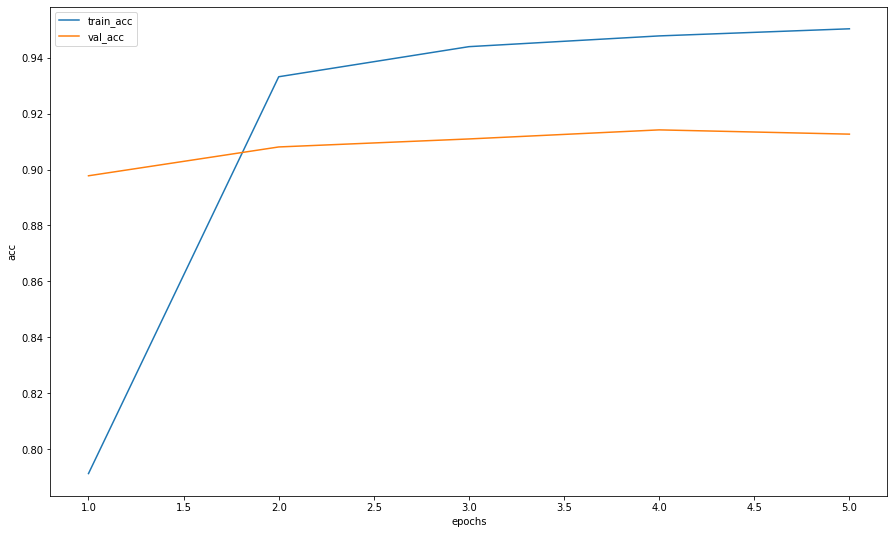

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(np.arange(1, len(loss)+1), acc, label="train_acc")
plt.plot(np.arange(1, len(loss)+1), val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Предсказания

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_ensemble, ex_img.unsqueeze(0))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_ensemble, imgs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1) #predictions

actual_labels = [val_dataset[id][1] for id in idxs] #actual

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.8000000000000002

Посмотрим, как хорошо предсказываем классы

In [ ]:
BATCH_SIZE = 128
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Normalized confusion matrix


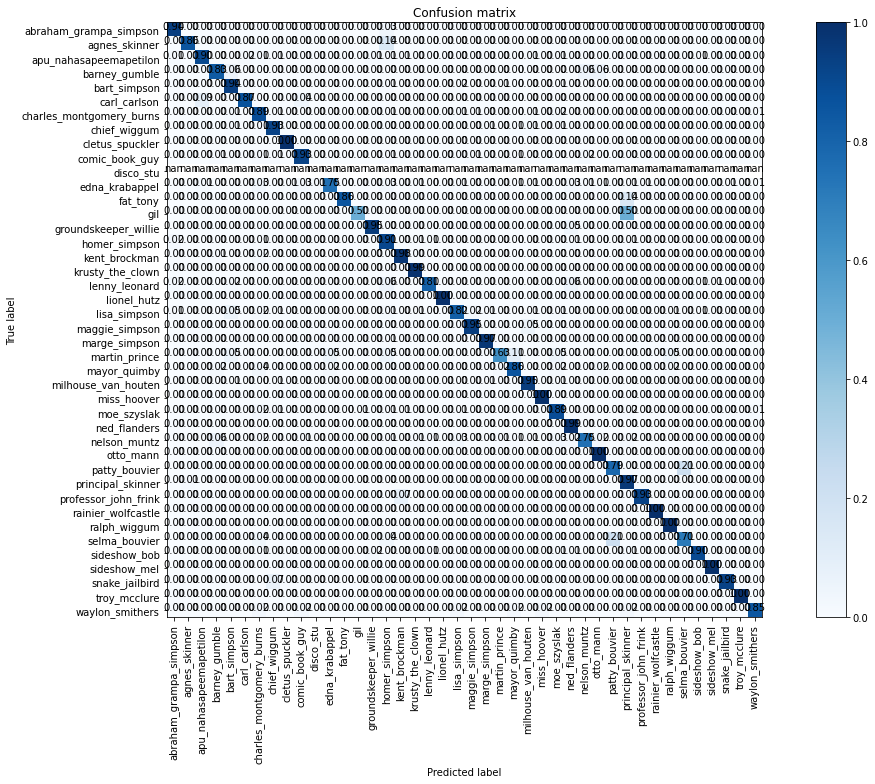

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all = show_confusion_matrix_fucn(model_ensemble, 42)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, 42)

[217, 7, 165, 18, 317, 23, 287, 248, 9, 112, 0, 144, 7, 8, 22, 573, 124, 297, 86, 1, 387, 19, 322, 19, 57, 270, 3, 374, 343, 109, 3, 14, 283, 14, 8, 15, 28, 235, 9, 14, 2, 41]
42
Accuracy of abraham_grampa_simpson : 94 %
Accuracy of agnes_skinner : 85 %
Accuracy of apu_nahasapeemapetilon : 90 %
Accuracy of barney_gumble : 83 %
Accuracy of bart_simpson : 94 %
Accuracy of carl_carlson : 86 %
Accuracy of charles_montgomery_burns : 88 %
Accuracy of chief_wiggum : 92 %
Accuracy of cletus_spuckler : 100 %
Accuracy of comic_book_guy : 92 %
Accuracy of disco_stu : -1 %
Accuracy of edna_krabappel : 75 %
Accuracy of fat_tony : 85 %
Accuracy of   gil : 50 %
Accuracy of groundskeeper_willie : 95 %
Accuracy of homer_simpson : 90 %
Accuracy of kent_brockman : 97 %
Accuracy of krusty_the_clown : 98 %
Accuracy of lenny_leonard : 81 %
Accuracy of lionel_hutz : 100 %
Accuracy of lisa_simpson : 82 %
Accuracy of maggie_simpson : 94 %
Accuracy of marge_simpson : 97 %
Accuracy of martin_prince : 63 %
Accura

Сохраним веса

In [ ]:
import copy

# сохранить веса нашей нейросети model
model_weights = copy.deepcopy(model_ensemble.state_dict())
torch.save(model_weights, "path_to\\model_wights_ensemble.pth") 

Еще сетка: EfficientNet

In [43]:
!pip install --upgrade efficientnet-pytorch

Requirement already up-to-date: efficientnet-pytorch in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [55]:
from torch import nn
# import pretrainedmodels
from efficientnet_pytorch import EfficientNet

def get_model(model_name: str, num_classes: int, pretrained: str = "imagenet"):
#берем последний слой классификатора
#размерность признаков, которые подаются на вход линейному слою
#и заменяем его на наш
    model = EfficientNet.from_pretrained(model_name, num_classes=num_classes).cuda()

    return model

model_name = 'efficientnet-b4'
model_efficient4 = get_model(model_name, 42)
model_efficient4

Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [56]:
train_dataset = new_train_dataset
val_dataset = val_dataset
optimizer = torch.optim.AdamW(model_efficient4.parameters()) #обучаем классификатор

In [57]:
### Запустим обучение (Train) нейросети ###
# model_cnn
history = train(train_dataset, val_dataset, model=model_efficient4, epochs=2, batch_size=32, optimizer=optimizer)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.6110101276281565


epoch:  50%|█████     | 1/2 [07:19<07:19, 439.97s/it]


Epoch 001 train_loss: 0.6110     val_loss 0.3214 train_acc 0.8499 val_acc 0.9146
loss 0.39344159814959917


epoch: 100%|██████████| 2/2 [14:35<00:00, 437.86s/it]


Epoch 002 train_loss: 0.3934     val_loss 0.2194 train_acc 0.8968 val_acc 0.9488


Графики

In [58]:
loss, acc, val_loss, val_acc = zip(*history)

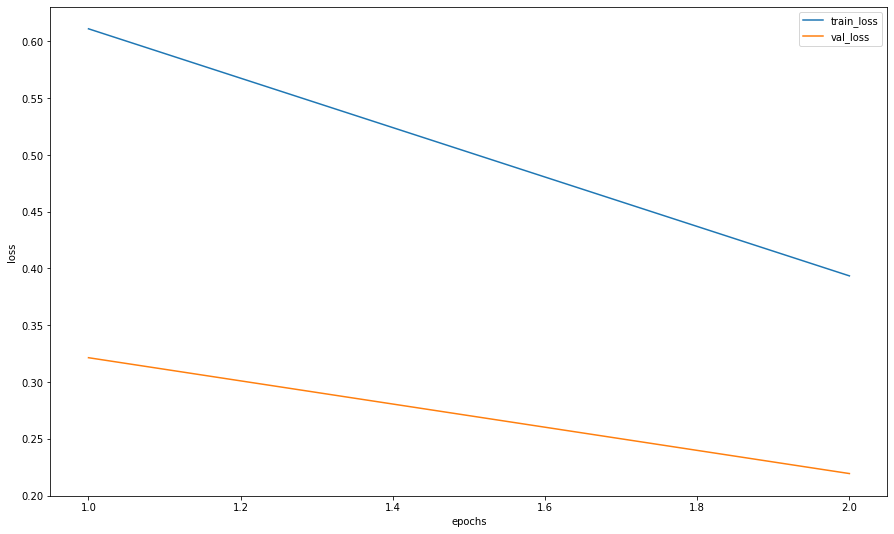

In [59]:
plt.figure(figsize=(15, 9))
plt.plot(np.arange(1, len(loss)+1), loss, label="train_loss")
plt.plot(np.arange(1, len(loss)+1), val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

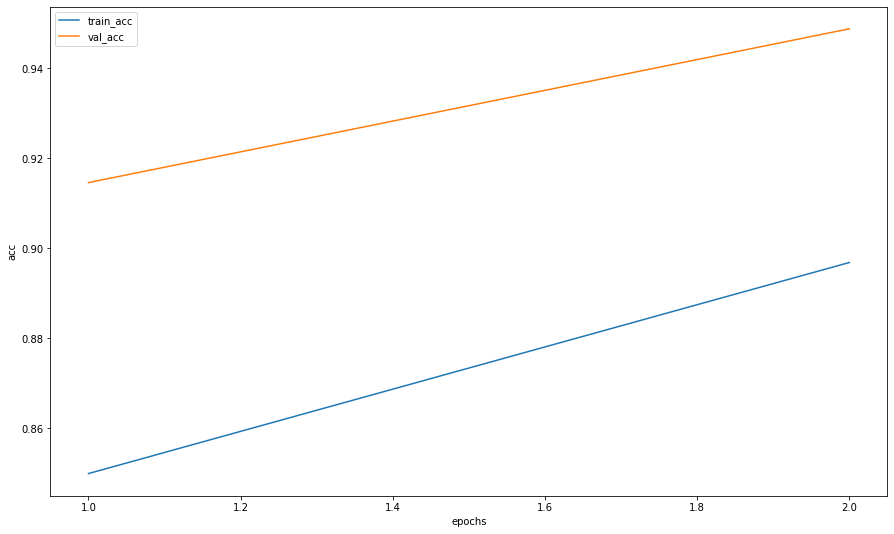

In [60]:
plt.figure(figsize=(15, 9))
plt.plot(np.arange(1, len(loss)+1), acc, label="train_acc")
plt.plot(np.arange(1, len(loss)+1), val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Предсказания

In [61]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [63]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_efficient4, ex_img.unsqueeze(0))

In [64]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_efficient4, imgs)

In [65]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [66]:
y_pred = np.argmax(probs_ims,-1) #predictions

actual_labels = [val_dataset[id][1] for id in idxs] #actual

In [67]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

1.0

Посмотрим, как хорошо предсказываем классы

In [68]:
BATCH_SIZE = 128
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

Normalized confusion matrix


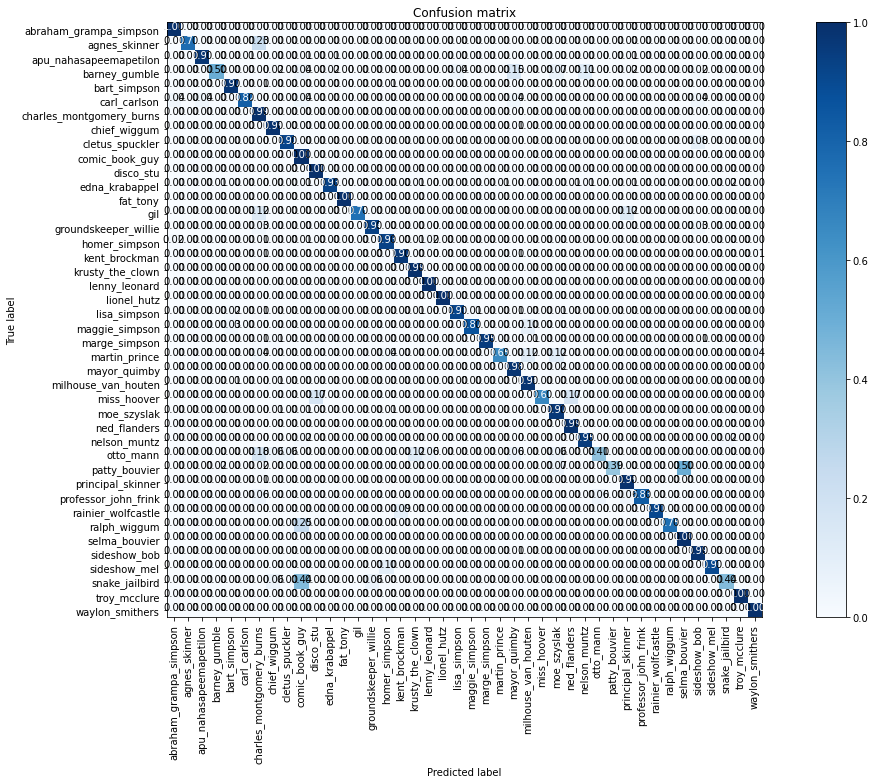

In [72]:
# Построим confusion_matrix
y_test_all, predictions_all = show_confusion_matrix_fucn(model_efficient4, 42)

In [73]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, 42)

[214, 13, 158, 46, 333, 28, 273, 234, 12, 86, 1, 120, 6, 8, 31, 596, 126, 295, 64, 1, 368, 31, 339, 26, 45, 264, 6, 357, 363, 85, 17, 46, 296, 18, 11, 28, 3, 215, 10, 16, 2, 43]
42
Accuracy of abraham_grampa_simpson : 100 %
Accuracy of agnes_skinner : 76 %
Accuracy of apu_nahasapeemapetilon : 97 %
Accuracy of barney_gumble : 50 %
Accuracy of bart_simpson : 97 %
Accuracy of carl_carlson : 82 %
Accuracy of charles_montgomery_burns : 99 %
Accuracy of chief_wiggum : 99 %
Accuracy of cletus_spuckler : 91 %
Accuracy of comic_book_guy : 100 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 92 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 75 %
Accuracy of groundskeeper_willie : 93 %
Accuracy of homer_simpson : 92 %
Accuracy of kent_brockman : 96 %
Accuracy of krusty_the_clown : 99 %
Accuracy of lenny_leonard : 100 %
Accuracy of lionel_hutz : 100 %
Accuracy of lisa_simpson : 91 %
Accuracy of maggie_simpson : 87 %
Accuracy of marge_simpson : 94 %
Accuracy of martin_prince : 65 %


Сохраним веса

In [75]:
import copy

# сохранить веса нашей нейросети model
model_weights = copy.deepcopy(model_efficient4.state_dict())
torch.save(model_weights, "path_to\\model_wights_efficient4.pth") 

### Submit на Kaggle

In [77]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_efficient4, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [78]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)
# файл появится у вас на гугл диске

In [79]:
! ls 

 characters_illustration.png  'path_to\model_wights_efficient4.pth'   testset
 gdrive			       sample_data			      train
 label_encoder.pkl	       sample_submission.csv
